# Dropout CGCNN (dropout)
Similar to our standard CGCNN, except with the final dense layers having dropouts during both training and prediction.

# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed and split data from our cache

In [2]:
import pickle


model_name = 'Dropout NN'
dropout = 0.3

with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val, docs_test = splits['docs_train'], splits['docs_val'], splits['docs_test']
sdts_train, sdts_val, sdts_test = splits['sdts_train'], splits['sdts_val'], splits['sdts_test']
targets_train, targets_val, targets_test = splits['targets_train'], splits['targets_val'], splits['targets_test']

# Where we put the intermediate results for this notebook
prefix = './'

Initialize the CGCNN `net` class with dropout

In [3]:
from torch.optim import Adam
import skorch.callbacks.base
from skorch import callbacks  # needs skorch >= 0.4  
from skorch import NeuralNetRegressor
from skorch.dataset import CVSplit
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


# Callback to checkpoint parameters every time there is a new best for validation loss
cp = callbacks.Checkpoint(monitor='valid_loss_best', fn_prefix='valid_best_')

# Callback to load the checkpoint with the best validation loss at the end of training
class train_end_load_best_valid_loss(callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('valid_best_params.pt')
load_best_valid_loss = train_end_load_best_valid_loss()

# Callback to set the learning rate dynamically
LR_schedule = callbacks.lr_scheduler.LRScheduler('MultiStepLR', milestones=[100], gamma=0.1)

net = NeuralNetRegressor(
    CrystalGraphConvNet,
    module__orig_atom_fea_len=orig_atom_fea_len,
    module__nbr_fea_len=nbr_fea_len,
    batch_size=214,
    module__classification=False,
    lr=0.0056,
    max_epochs=150,
    module__atom_fea_len=46,
    module__h_fea_len=83,
    module__n_conv=8,
    module__n_h=4,
    optimizer=Adam,
    iterator_train__pin_memory=True,
    iterator_train__num_workers=0,
    iterator_train__collate_fn=collate_pool,
    iterator_train__shuffle=True,
    iterator_valid__pin_memory=True,
    iterator_valid__num_workers=0,
    iterator_valid__collate_fn=collate_pool,
    iterator_valid__shuffle=False,
    device=device,
    criterion=torch.nn.L1Loss,
    dataset=MergeDataset,
    callbacks=[cp, load_best_valid_loss, LR_schedule],
    module__dropout=dropout,
)

# Training GP
We can train a new model...

In [4]:
net.initialize()
net.fit(sdts_train, targets_train)

Re-initializing module because the following parameters were re-set: atom_fea_len, classification, dropout, h_fea_len, n_conv, n_h, nbr_fea_len, orig_atom_fea_len.
Re-initializing optimizer.
  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
      1        0.5302        0.4522     +  55.6232
      2        0.4008        0.3933     +  54.9439
      3        0.3770        0.3728     +  55.0262
      4        0.3490        0.3423     +  55.0737
      5        0.3723        0.3651        54.9976
      6        0.3250        0.3521        55.0326
      7        0.3253        0.3896        54.9331
      8        0.3258        0.3722        54.8688
      9        0.2987        0.3182     +  54.9386
     10        0.3057        0.2950     +  54.8734
     11        0.2946        0.3069        54.9190
     12        0.2692        0.2864     +  54.9926
     13        0.2916        0.3140        55.0534
     14        0.2880        0.2972        5

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=CrystalGraphConvNet(
    (embedding): Linear(in_features=98, out_features=46, bias=True)
    (convs): ModuleList(
      (0): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(beta=1, threshold=20)
      )
      (1): ConvLayer(
        (fc_full): Linear(in_features=98, out_features=92, bias=True)
        (sigmoid): Sigmoid()
        (softplus1): Softplus(beta=1, threshold=20)
        (bn1): BatchNorm1d(92, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (softplus2): Softplus(

In [ ]:
# Restart training in case first round was cut off
net.partial_fit(sdts_train, targets_train)

...or load whatever is cached

In [4]:
net.initialize()
net.load_params(f_history=prefix+'valid_best_history.json',
                f_optimizer=prefix+'valid_best_optimizer.pt', 
                f_params=prefix+'valid_best_params.pt')

Now we load the model

# Assess performance
## Validation
We used the results in this section to tune hyperparameters

In [5]:
from tqdm.notebook import tqdm
import numpy as np

# Make predictions
n_samples = 20
preds_val = np.array([net.predict(sdts_val).reshape(-1) for _ in tqdm(range(n_samples))])
targets_pred = preds_val.mean(axis=0).reshape(-1)
residuals = targets_pred - targets_val.reshape(-1)
stdevs = preds_val.std(axis=0).reshape(-1)

In [6]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.80
PPMCC = 0.89


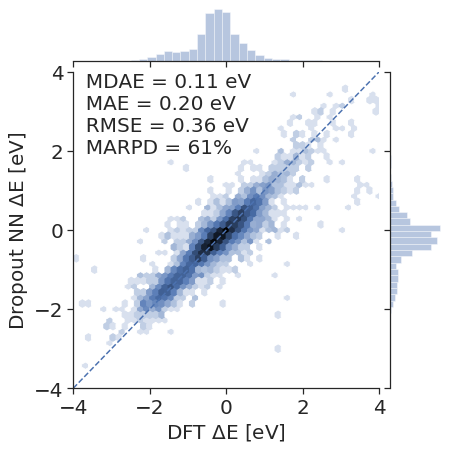

In [7]:
import pickle
import numpy as np
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
mdae = median_absolute_error(targets_val, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_val.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_val, targets_pred)
corr = np.corrcoef(targets_val.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

In [8]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the lower
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    upper_bound = norm.ppf(percentile)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

calibration_error = ((predicted_pi - observed_pi)**2).sum()
print('Calibration error = %.2f' % calibration_error)

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Calibration error = 2.51


In [9]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

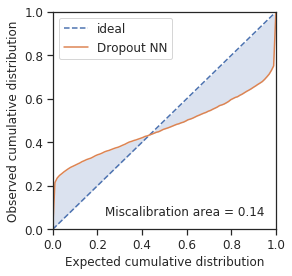

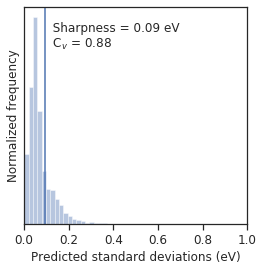

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected cumulative distribution')
_ = ax_ideal.set_ylabel('Observed cumulative distribution')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness/dispersion
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
dispersion = np.sqrt(((stdevs - stdevs.mean())**2).sum() / (len(stdevs)-1)) / stdevs.mean()
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV\n  C$_v$ = %.2f' % (sharpness, dispersion)
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  \nC$_v$ = %.2f  ' % (sharpness, dispersion)
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

## Test
Do this all over again, but for the test set

In [11]:
from tqdm.notebook import tqdm
import numpy as np


# Make predictions
n_samples = 20
preds_test = np.array([net.predict(sdts_test).reshape(-1) for _ in tqdm(range(n_samples))])
targets_pred = preds_test.mean(axis=0).reshape(-1)
residuals = targets_pred - targets_test.reshape(-1)
stdevs = preds_test.std(axis=0).reshape(-1)

# Save the results
with open('test_predictions.pkl', 'wb') as file_handle:
    pickle.dump((residuals, stdevs), file_handle)

In [12]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 7.5/3  # 1/3 of a page
fontsize = 20
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

R2 = 0.79
PPMCC = 0.89


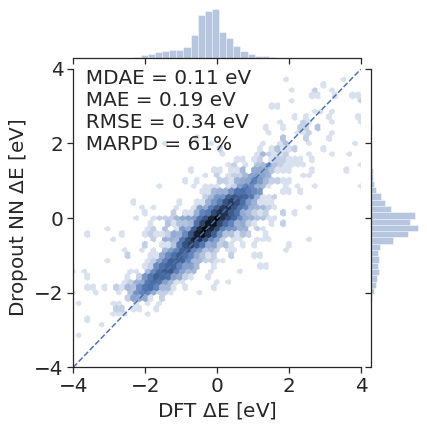

In [13]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (mean_absolute_error,
                             mean_squared_error,
                             r2_score,
                             median_absolute_error)


# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_test.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_test, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_test, targets_pred))
mdae = median_absolute_error(targets_test, targets_pred)
marpd = np.abs(2 * residuals /
               (np.abs(targets_pred) + np.abs(targets_test.reshape(-1)))
               ).mean() * 100
r2 = r2_score(targets_test, targets_pred)
corr = np.corrcoef(targets_test.reshape(-1), targets_pred)[0, 1]

# Report
text = ('  MDAE = %.2f eV\n' % mdae + 
        '  MAE = %.2f eV\n' % mae + 
        '  RMSE = %.2f eV\n' % rmse + 
        '  MARPD = %i%%\n' % marpd)
print('R2 = %.2f' % r2)
print('PPMCC = %.2f' % corr)
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=fontsize)

# Save figure
plt.savefig('parity.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [14]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Define a normalized bell curve we'll be using to calculate calibration
norm = stats.norm(loc=0, scale=1)


def calculate_density(percentile):
    '''
    Calculate the fraction of the residuals that fall within the lower
    `percentile` of their respective Gaussian distributions, which are
    defined by their respective uncertainty estimates.
    '''
    # Find the normalized bounds of this percentile
    upper_bound = norm.ppf(percentile)

    # Normalize the residuals so they all should fall on the normal bell curve
    normalized_residuals = residuals.reshape(-1) / stdevs.reshape(-1)

    # Count how many residuals fall inside here
    num_within_quantile = 0
    for resid in normalized_residuals:
        if resid <= upper_bound:
            num_within_quantile += 1

    # Return the fraction of residuals that fall within the bounds
    density = num_within_quantile / len(residuals)
    return density


predicted_pi = np.linspace(0, 1, 100)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

calibration_error = ((predicted_pi - observed_pi)**2).sum()
print('Calibration error = %.2f' % calibration_error)

/global/homes/k/ktran/miniconda3/envs/gaspy/lib/python3.6/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Calibration error = 2.48


In [15]:
%matplotlib inline
import seaborn as sns


# Set figure defaults
width = 4  # Because it looks good
fontsize = 12
rc = {'figure.figsize': (width, width),
      'font.size': fontsize,
      'axes.labelsize': fontsize,
      'axes.titlesize': fontsize,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'legend.fontsize': fontsize}
sns.set(rc=rc)
sns.set_style('ticks')

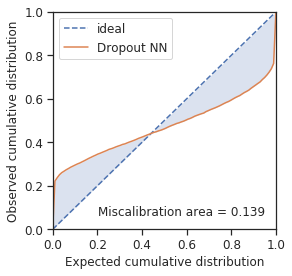

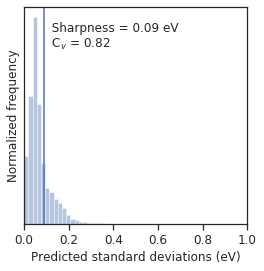

In [16]:
import numpy as np
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, LineString
from shapely.ops import polygonize, unary_union


# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected cumulative distribution')
_ = ax_ideal.set_ylabel('Observed cumulative distribution')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
x, y = polygon.exterior.xy # original data
ls = LineString(np.c_[x, y]) # closed, non-simple
lr = LineString(ls.coords[:] + ls.coords[0:1])
mls = unary_union(lr)
polygon_area_list =[poly.area for poly in polygonize(mls)]
miscalibration_area = np.asarray(polygon_area_list).sum()

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.3f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right',
         fontsize=fontsize)

# Save
plt.savefig('calibration.pdf', dpi=300, bbox_inches='tight', transparent=True)


# Plot sharpness curve
xlim = [0., 1.]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviations (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness/dispersion
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
dispersion = np.sqrt(((stdevs - stdevs.mean())**2).sum() / (len(stdevs)-1)) / stdevs.mean()
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV\n  C$_v$ = %.2f' % (sharpness, dispersion)
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  \nC$_v$ = %.2f  ' % (sharpness, dispersion)
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align,
                  fontsize=fontsize)

# Save
plt.savefig('sharpness.pdf', dpi=300, bbox_inches='tight', transparent=True)

In [43]:
from scipy.stats import norm


nll_list = []
for (res, std) in zip(residuals, stdevs):
    nll_list.append(norm.logpdf(res, scale=std))

nll = -1 * np.sum(nll_list)

print('NLL = {}'.format(nll))

NLL = 7.382192777992896e+17
